In [43]:
import networkx as nx
import community
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [30]:
cluster = pd.read_csv('../data/topic_clusters.csv')

In [33]:
cluster = cluster[cluster['cluster_id'] != 6]

In [34]:
cluster.head()

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,toxicity_evolution,avg_toxicity,sample_topics,topic_indices
0,0,22,141317,"['covidiots', 'viruses', 'infected', 'vaccinat...",1.227273,"{'2020': 2356, '2021': 135250, '2022': 2978, '...","{'2020': {'2020-01': {'avg_toxicity': 0.0587, ...",0.050925,"['covid vaccinated', 'covid vaccinated vaccina...","[192, 321, 66, 195, 514, 388, 637, 653, 529, 8..."
1,1,20,14679,"['rents', 'hdbs', 'housing', 'homeowners', 'bu...",1.350000,"{'2020': 403, '2021': 4461, '2022': 6891, '202...","{'2020': {'2020-02': {'avg_toxicity': 0.0572, ...",0.086916,"['bto btos hdb housing', 'btos flats hdb valua...","[194, 707, 196, 519, 712, 649, 703, 278, 603, ..."
2,2,17,9207,"['rsg', 'sgsecure', 'sgeans', 'sgraw', 'sgrean...",0.764706,"{'2020': 1285, '2021': 1376, '2022': 2688, '20...","{'2020': {'2020-02': {'avg_toxicity': 0.0565, ...",0.049124,"['rsg sgraw sgs', 'sgeans sgraw sgs', 'sgraw s...","[481, 389, 425, 201, 75, 409, 587, 655, 559, 6..."
3,3,15,8096,"['cyclist', 'taxi', 'bicycle', 'jaywalking', '...",1.133333,"{'2020': 3858, '2021': 1606, '2022': 762, '202...","{'2020': {'2020-01': {'avg_toxicity': 0.0284, ...",0.056845,"['driving pedestrian pedestrians traffic', 'dr...","[577, 70, 264, 9, 235, 14, 591, 497, 689, 52, ..."
4,4,12,7217,"['mask', 'masks', 'maskoff', 'maskless', 'helm...",0.750000,"{'2020': 1558, '2021': 2163, '2022': 3496}","{'2020': {'2020-08': {'avg_toxicity': 0.0425, ...",0.086982,"['mask masking maskoff masks', 'mask maskless ...","[128, 385, 223, 132, 267, 109, 302, 210, 406, ..."


In [13]:
def preprocess_for_network(cluster_df):
    # Convert string representations to actual lists/dicts
    cluster_df = cluster_df.copy()
    cluster_df['unique_keywords'] = cluster_df['unique_keywords'].apply(eval)
    cluster_df['temporal_evolution'] = cluster_df['temporal_evolution'].apply(eval)
    cluster_df['sample_topics'] = cluster_df['sample_topics'].apply(eval)
    cluster_df['toxicity_evolution'] = cluster_df['toxicity_evolution'].apply(eval)
    return cluster_df

In [35]:
cluster_processed = preprocess_for_network(cluster)

In [16]:
def create_semantic_network(cluster_df, min_similarity=0.2):
    """Create network based on semantic, temporal, and toxicity similarity"""
    G = nx.Graph()
    
    # Add nodes with toxicity information
    for idx, row in cluster_df.iterrows():
        G.add_node(row['cluster_id'],
                  keywords=row['unique_keywords'],
                  posts=row['total_posts'],
                  temporal=row['temporal_evolution'],
                  toxicity=row['avg_toxicity'],
                  toxicity_evolution=row['toxicity_evolution'])
    
    def calculate_similarity(node1, node2):
        # Get node data
        kw1 = set(G.nodes[node1]['keywords'])
        kw2 = set(G.nodes[node2]['keywords'])
        temp1 = G.nodes[node1]['temporal']
        temp2 = G.nodes[node2]['temporal']
        tox1 = G.nodes[node1]['toxicity_evolution']
        tox2 = G.nodes[node2]['toxicity_evolution']
        
        # Keyword similarity (Jaccard)
        keyword_sim = len(kw1 & kw2) / len(kw1 | kw2) if len(kw1 | kw2) > 0 else 0
        
        # Get shared years
        shared_years = set(temp1.keys()) & set(temp2.keys())
        if not shared_years:
            return 0, 0, 0, 0, []
        
        # Calculate temporal similarity
        temporal_sim = 0
        toxicity_sim = 0
        
        for year in shared_years:
            # Volume similarity
            ratio = min(temp1[year], temp2[year]) / max(temp1[year], temp2[year])
            temporal_sim += ratio
            
            # Toxicity pattern similarity
            if year in tox1 and year in tox2:
                months1 = set(tox1[year].keys())
                months2 = set(tox2[year].keys())
                shared_months = months1 & months2
                
                if shared_months:
                    month_sims = []
                    for month in shared_months:
                        tox_diff = abs(tox1[year][month]['avg_toxicity'] - 
                                    tox2[year][month]['avg_toxicity'])
                        month_sims.append(1 - min(tox_diff, 1))  # Normalize difference
                    toxicity_sim += sum(month_sims) / len(month_sims)
        
        temporal_sim = temporal_sim / len(shared_years)
        toxicity_sim = toxicity_sim / len(shared_years)
        
        # Combined similarity with toxicity component
        combined_sim = 0.5 * keyword_sim + 0.25 * temporal_sim + 0.25 * toxicity_sim
        
        return combined_sim, keyword_sim, temporal_sim, toxicity_sim, list(shared_years)
    
    # Calculate similarities and add edges
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            node1, node2 = nodes[i], nodes[j]
            
            combined_sim, kw_sim, temp_sim, tox_sim, shared_years = calculate_similarity(node1, node2)
            
            if combined_sim > min_similarity:
                G.add_edge(node1, node2, 
                          weight=combined_sim,
                          keyword_sim=kw_sim,
                          temporal_sim=temp_sim,
                          toxicity_sim=tox_sim,
                          shared_years=shared_years)
    
    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Network density: {nx.density(G):.3f}")
    return G

In [36]:
G = create_semantic_network(cluster_processed)

Created network with 145 nodes and 4156 edges
Network density: 0.398


In [8]:
def visualize_network(G, cluster_df, min_edge_weight=0.3):
    plt.figure(figsize=(20, 20))
    
    # Use spring layout with adjusted parameters
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Prepare node attributes
    node_sizes = []
    node_colors = []
    node_labels = {}
    post_counts = []  # Store actual post counts for legend
    
    for node in G.nodes():
        # Get post count
        posts = cluster_df[cluster_df['cluster_id'] == node]['total_posts'].iloc[0]
        post_counts.append(posts)
        
        # Size based on log of post count for better scaling
        size = 1000 * np.log1p(posts/100)  # Adjusted scaling
        node_sizes.append(size)
        
        # Color based on main year
        temporal = cluster_df[cluster_df['cluster_id'] == node]['temporal_evolution'].iloc[0]
        main_year = max(temporal.items(), key=lambda x: x[1])[0]
        node_colors.append(int(main_year))
        
        # Create clearer labels
        keywords = cluster_df[cluster_df['cluster_id'] == node]['unique_keywords'].iloc[0]
        node_labels[node] = f"C{node}\n{', '.join(keywords[:2])}"
    
    # Draw edges with weight-based transparency
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for _, _, d in edges]
    
    # Filter edges by weight for clarity
    significant_edges = [(u, v) for u, v, d in edges if d['weight'] >= min_edge_weight]
    edge_colors = ['gray' if (u, v) in significant_edges else 'lightgray' for u, v, _ in edges]
    
    nx.draw_networkx_edges(G, pos, 
                          edgelist=list(edges),
                          edge_color=edge_colors,
                          width=[w*2 for w in edge_weights],
                          alpha=0.3)
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=node_colors,
                                 cmap=plt.cm.viridis,
                                 alpha=0.7)
    
    # Add labels with better positioning
    for node, (x, y) in pos.items():
        # Scale font size with node size
        font_size = max(8, min(12, np.log1p(node_sizes[list(G.nodes()).index(node)]/100)))
        plt.text(x, y, node_labels[node],
                fontsize=font_size,
                ha='center', va='center',
                bbox=dict(facecolor='white', 
                         alpha=0.7,
                         edgecolor='none',
                         boxstyle='round,pad=0.5'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                              norm=plt.Normalize(vmin=2020, vmax=2023))
    plt.colorbar(sm, label='Main Year')
    
    # Add title
    plt.title('Topic Cluster Network\n' +
             f'{G.number_of_nodes()} nodes, {G.number_of_edges()} edges\n' +
             'Node size: Total posts, Color: Main year, Edge width: Similarity',
             pad=20, fontsize=14)
    
    # Add legend for node sizes using actual post counts
    legend_posts = [min(post_counts), 
                   int(np.median(post_counts)), 
                   max(post_counts)]
    legend_sizes = [1000 * np.log1p(p/100) for p in legend_posts]
    
    legend_elements = [plt.scatter([], [], s=s,
                                 c='gray', alpha=0.7,
                                 label=f'{p:,} posts')
                      for s, p in zip(legend_sizes, legend_posts)]
    
    plt.legend(handles=legend_elements,
              title='Post Counts',
              loc='upper left',
              bbox_to_anchor=(1.1, 1))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\ch8765\AppData\Local\Temp\ipykernel_5904\4114446087.py:67: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Main Year')


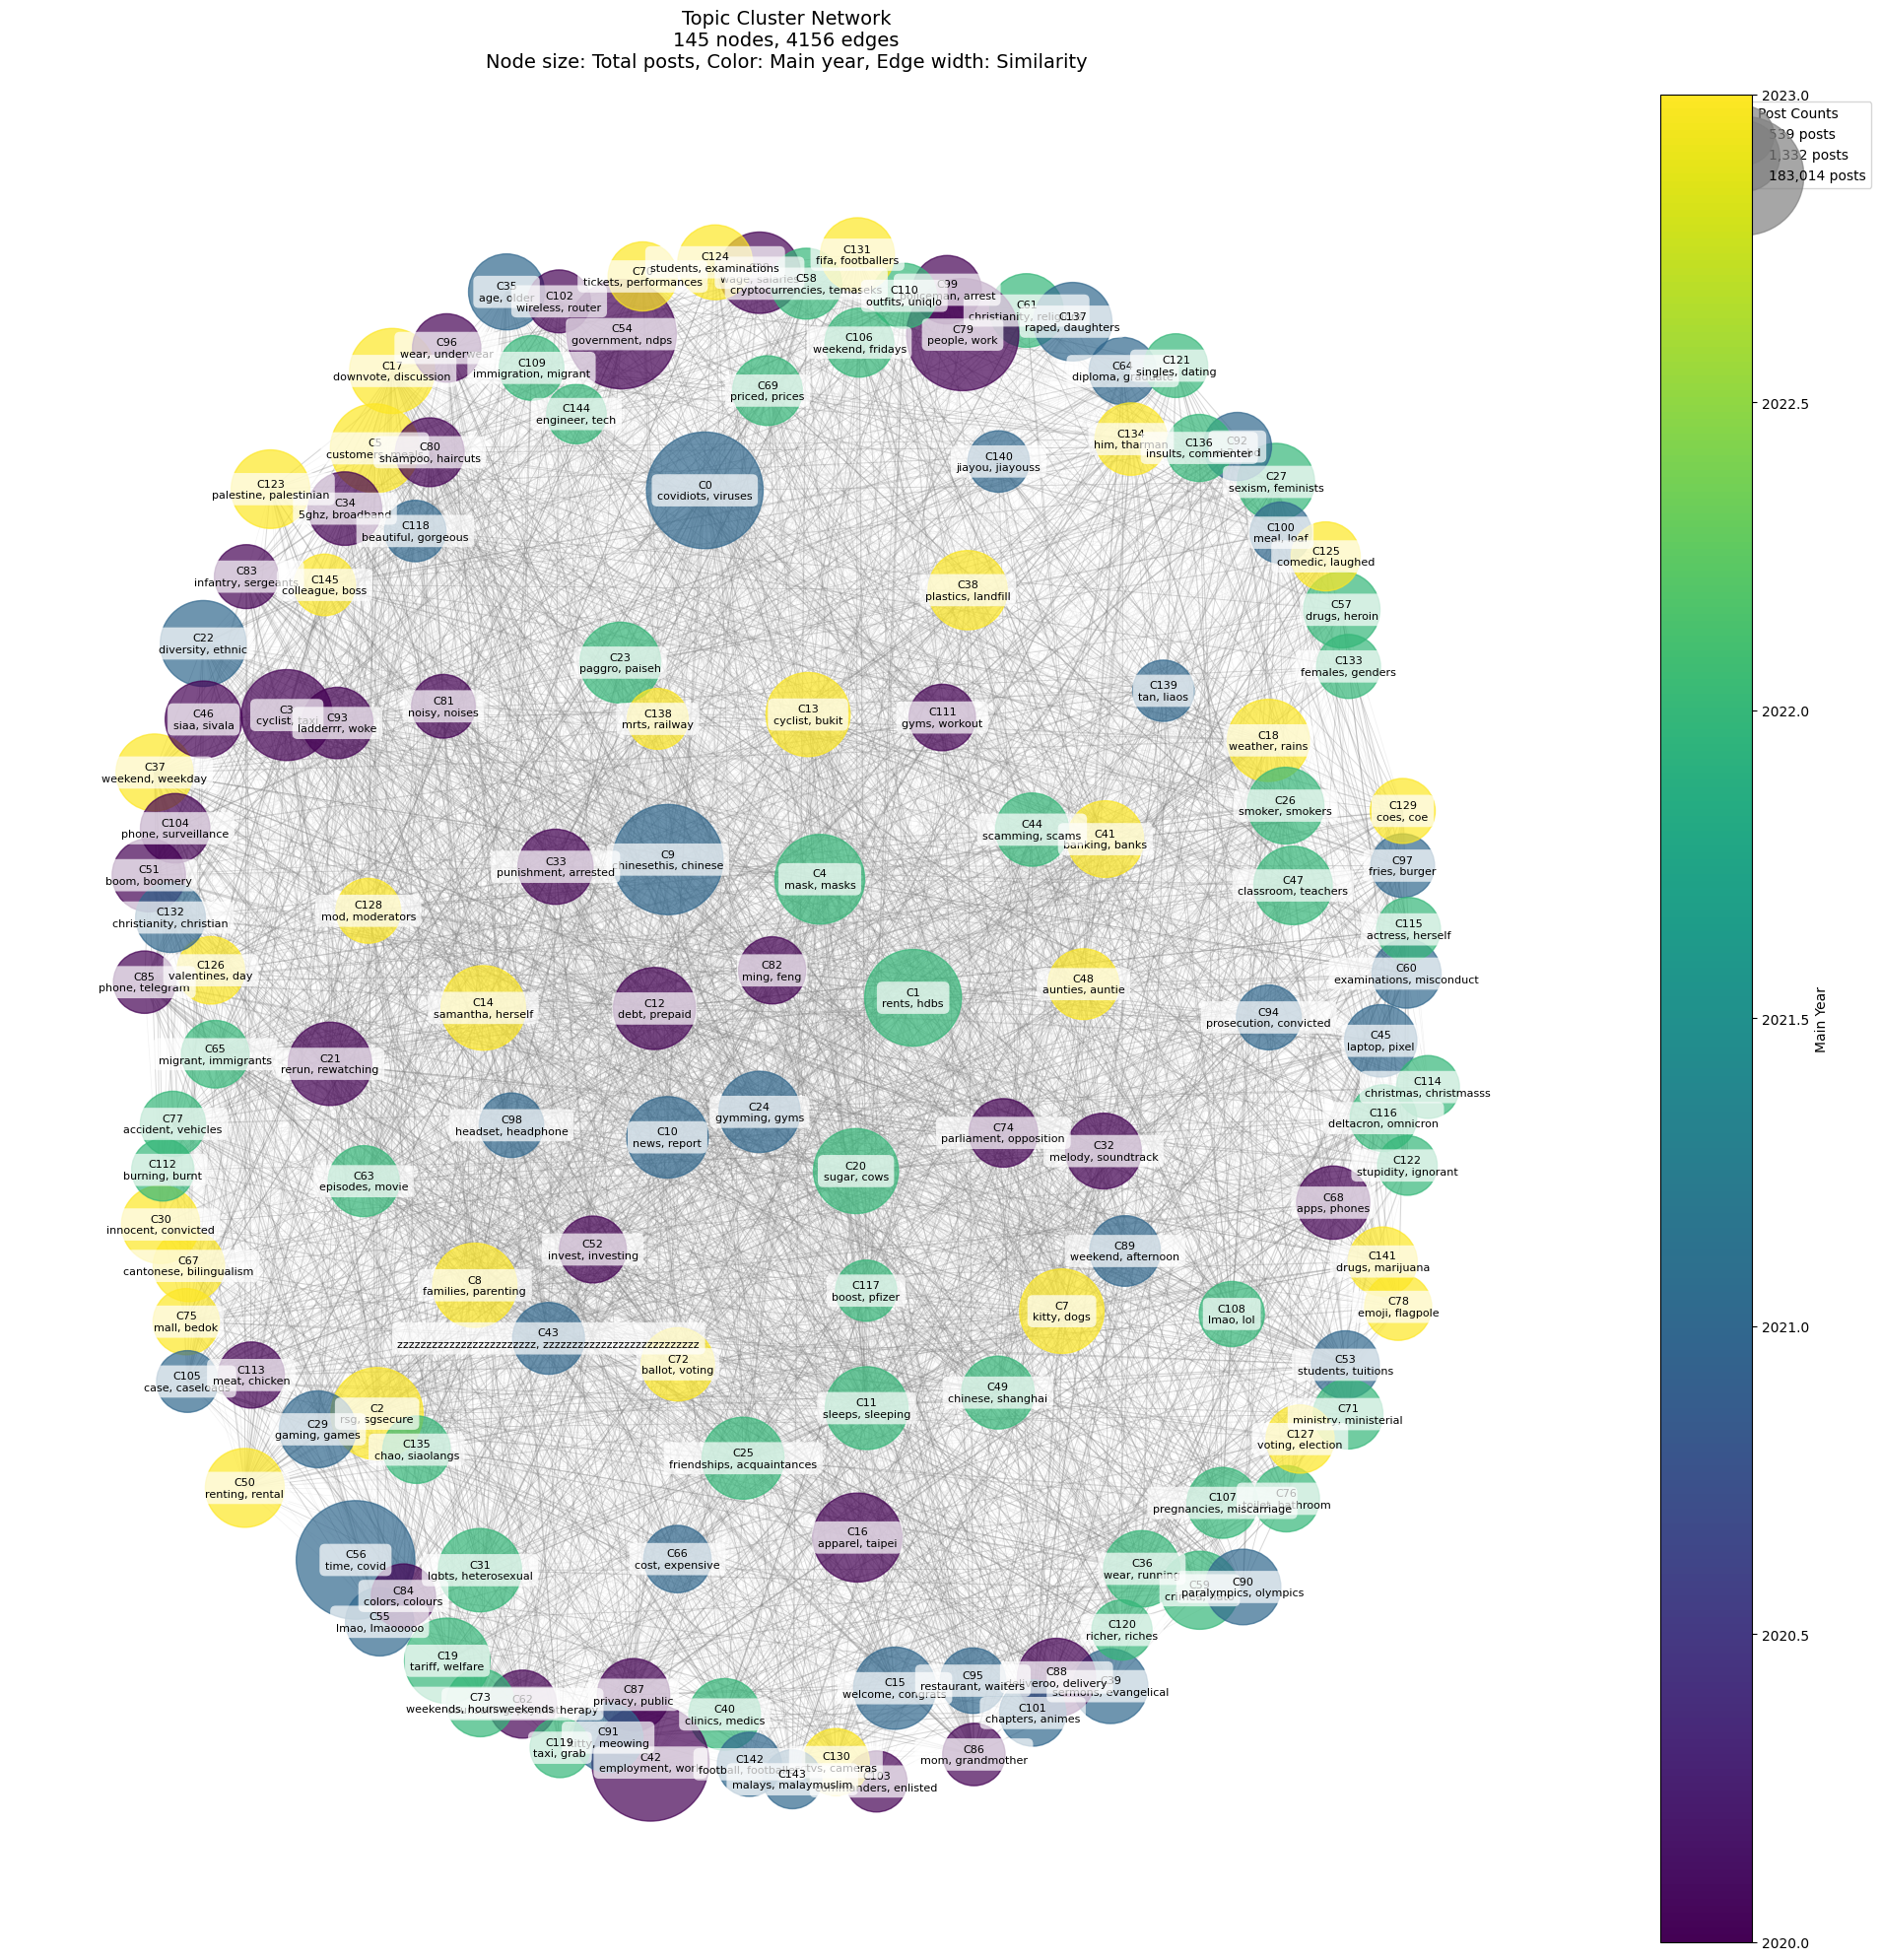

In [38]:
visualize_network(G, cluster_processed, min_edge_weight=0.3)

In [18]:
def analyze_network(G, cluster_df):
    """Analyze network structure and relationships with toxicity insights"""
    print("\nNetwork Analysis:")
    
    # Calculate centrality measures
    try:
        eigen_centrality = nx.eigenvector_centrality(G, weight='weight')
        print("\nMost central clusters:")
        for node, score in sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
            row = cluster_df[cluster_df['cluster_id'] == node].iloc[0]
            keywords = row['unique_keywords']
            posts = row['total_posts']
            toxicity = row['avg_toxicity']
            print(f"Cluster {node}: {', '.join(keywords[:3])} ({posts:,} posts)")
            print(f"Avg Toxicity: {toxicity:.3f} - Centrality Score: {score:.3f}")
    except:
        print("Could not calculate eigenvector centrality (possibly due to network structure)")
    
    # Analyze connections
    print("\nMost meaningful cluster relationships:")
    edges = [(u, v, d) for u, v, d in G.edges(data=True)]
    for u, v, d in sorted(edges, key=lambda x: x[2]['weight'], reverse=True)[:5]:
        u_row = cluster_df[cluster_df['cluster_id'] == u].iloc[0]
        v_row = cluster_df[cluster_df['cluster_id'] == v].iloc[0]
        
        print(f"\nConnection strength: {d['weight']:.3f}")
        print(f"Keyword similarity: {d['keyword_sim']:.3f}")
        print(f"Temporal similarity: {d['temporal_sim']:.3f}")
        print(f"Toxicity pattern similarity: {d['toxicity_sim']:.3f}")
        print(f"Cluster {u}: {', '.join(u_row['unique_keywords'][:3])} (toxicity: {u_row['avg_toxicity']:.3f})")
        print(f"Cluster {v}: {', '.join(v_row['unique_keywords'][:3])} (toxicity: {v_row['avg_toxicity']:.3f})")
        print(f"Shared years: {sorted(d['shared_years'])}")
    
    # Community detection with toxicity analysis
    if G.number_of_edges() > 0:
        communities = nx.community.louvain_communities(G)
        print(f"\nCommunity Analysis ({len(communities)} communities detected):")
        
        for idx, community in enumerate(sorted(communities, key=len, reverse=True)[:3]):
            print(f"\nCommunity {idx+1} (Size: {len(community)})")
            
            # Calculate community toxicity statistics
            community_toxicity = [cluster_df[cluster_df['cluster_id'] == node]['avg_toxicity'].iloc[0] 
                                for node in community]
            avg_toxicity = sum(community_toxicity) / len(community_toxicity)
            
            print(f"Average community toxicity: {avg_toxicity:.3f}")
            print("Key clusters:")
            for node in community:
                row = cluster_df[cluster_df['cluster_id'] == node].iloc[0]
                print(f"  Cluster {node}: {', '.join(row['unique_keywords'][:3])} "
                      f"({row['total_posts']:,} posts, toxicity: {row['avg_toxicity']:.3f})")
    
    # Toxicity-based network metrics
    print("\nToxicity-Based Network Metrics:")
    node_toxicities = nx.get_node_attributes(G, 'toxicity')
    avg_network_toxicity = sum(node_toxicities.values()) / len(node_toxicities)
    print(f"Average network toxicity: {avg_network_toxicity:.3f}")
    
    # Calculate toxicity assortativity
    toxicity_pairs = []
    for u, v in G.edges():
        toxicity_pairs.append((node_toxicities[u], node_toxicities[v]))
    
    if toxicity_pairs:
        correlation = np.corrcoef([p[0] for p in toxicity_pairs], 
                                [p[1] for p in toxicity_pairs])[0,1]
        print(f"Toxicity assortativity correlation: {correlation:.3f}")
    
    # Basic network metrics
    print("\nNetwork Metrics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.3f}")
    if G.number_of_edges() > 0:
        print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
        print("\nDegree Statistics:")
        degrees = [d for n, d in G.degree()]
        print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
        print(f"Maximum degree: {max(degrees)}")

In [37]:
analyze_network(G, cluster_processed)


Network Analysis:

Most central clusters:
Cluster 7: kitty, dogs, leashed (4,416 posts)
Avg Toxicity: 0.045 - Centrality Score: 0.141
Cluster 8: families, parenting, childcare (4,321 posts)
Avg Toxicity: 0.087 - Centrality Score: 0.138
Cluster 11: sleeps, sleeping, sleep (3,779 posts)
Avg Toxicity: 0.044 - Centrality Score: 0.136
Cluster 12: debt, prepaid, cards (3,535 posts)
Avg Toxicity: 0.051 - Centrality Score: 0.136
Cluster 4: mask, masks, maskoff (7,217 posts)
Avg Toxicity: 0.087 - Centrality Score: 0.134

Most meaningful cluster relationships:

Connection strength: 0.523
Keyword similarity: 0.091
Temporal similarity: 0.925
Toxicity pattern similarity: 0.986
Cluster 48: aunties, auntie, auntiee (toxicity: 0.056)
Cluster 106: weekend, fridays, monday (toxicity: 0.054)
Shared years: ['2020']

Connection strength: 0.499
Keyword similarity: 0.000
Temporal similarity: 0.996
Toxicity pattern similarity: 0.998
Cluster 68: apps, phones, apple (toxicity: 0.042)
Cluster 75: mall, bedok, m

In [41]:
def save_network_data(G, directory="network_data", filename="network_data.json"):
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    
    # Create full file path
    filepath = os.path.join(directory, filename)
    
    # Convert NetworkX graph to a format suitable for visualization
    network_data = {
        "nodes": [],
        "edges": [],
        "metadata": {
            "num_nodes": G.number_of_nodes(),
            "num_edges": G.number_of_edges(),
            "density": nx.density(G),
            "avg_clustering": nx.average_clustering(G)
        }
    }
    
    # Add nodes with their attributes
    for node in G.nodes():
        node_data = {
            "id": str(node),
            "keywords": G.nodes[node].get('keywords', []),
            "posts": G.nodes[node].get('posts', 0),
            "toxicity": G.nodes[node].get('toxicity', 0)
        }
        network_data["nodes"].append(node_data)
    
    # Add edges with their attributes
    for u, v, data in G.edges(data=True):
        edge_data = {
            "source": str(u),
            "target": str(v),
            "weight": data.get('weight', 0),
            "keyword_sim": data.get('keyword_sim', 0),
            "temporal_sim": data.get('temporal_sim', 0),
            "toxicity_sim": data.get('toxicity_sim', 0)
        }
        network_data["edges"].append(edge_data)
    
    # Save to file
    with open(filepath, 'w') as f:
        json.dump(network_data, f)
    
    print(f"Network data saved to {filepath}")
    return network_data

In [44]:
network_data = save_network_data(G, directory="../data")

Network data saved to ../data\network_data.json
